In [117]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor,GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE
from joblib import dump, load


Reading the accompanying .names file, I have learned that there are ten features for each cell nucleus, and these have ten features have 3 results each - the mean, standard error, and "worst".

In [102]:
# 1. Data Collection
columns = ['ID_Number','Diagnosis','Radius','Texture','Perimeter','Area','Smoothness','Compactness','Concavity','Concave_points','Symmetry','Fractal_Dimension','Radius_SE','Texture_SE','Perimeter_SE','Area_SE','Smoothness_SE','Compactness_SE','Concavity_SE','Concave_points_SE','Symmetry_SE','Fractal_Dimension_SE','Radius_Worst','Texture_Worst','Perimeter_Worst','Area_Worst','Smoothness_Worst','Compactness_Worst','Concavity_Worst','Concave_points_Worst','Symmetry_Worst','Fractal_Dimension_Worst']
df = pd.read_csv('Data/wdbc.data', names=columns)
df['Diagnosis'] = df['Diagnosis'].map({'B':0,'M':1})
print(df.head())

   ID_Number  Diagnosis  Radius  Texture  Perimeter    Area  Smoothness  \
0     842302          1   17.99    10.38     122.80  1001.0     0.11840   
1     842517          1   20.57    17.77     132.90  1326.0     0.08474   
2   84300903          1   19.69    21.25     130.00  1203.0     0.10960   
3   84348301          1   11.42    20.38      77.58   386.1     0.14250   
4   84358402          1   20.29    14.34     135.10  1297.0     0.10030   

   Compactness  Concavity  Concave_points  ...  Radius_Worst  Texture_Worst  \
0      0.27760     0.3001         0.14710  ...         25.38          17.33   
1      0.07864     0.0869         0.07017  ...         24.99          23.41   
2      0.15990     0.1974         0.12790  ...         23.57          25.53   
3      0.28390     0.2414         0.10520  ...         14.91          26.50   
4      0.13280     0.1980         0.10430  ...         22.54          16.67   

   Perimeter_Worst  Area_Worst  Smoothness_Worst  Compactness_Worst  \
0  

In [103]:
# 2. Exploratory Data Analysis
class_distribution = df['Diagnosis'].value_counts(normalize=True)
print(class_distribution)

df.info()
df.describe()
df.isnull().sum()

Diagnosis
0    0.627417
1    0.372583
Name: proportion, dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID_Number                569 non-null    int64  
 1   Diagnosis                569 non-null    int64  
 2   Radius                   569 non-null    float64
 3   Texture                  569 non-null    float64
 4   Perimeter                569 non-null    float64
 5   Area                     569 non-null    float64
 6   Smoothness               569 non-null    float64
 7   Compactness              569 non-null    float64
 8   Concavity                569 non-null    float64
 9   Concave_points           569 non-null    float64
 10  Symmetry                 569 non-null    float64
 11  Fractal_Dimension        569 non-null    float64
 12  Radius_SE                569 non-null    float64
 13  Texture_S

ID_Number                  0
Diagnosis                  0
Radius                     0
Texture                    0
Perimeter                  0
Area                       0
Smoothness                 0
Compactness                0
Concavity                  0
Concave_points             0
Symmetry                   0
Fractal_Dimension          0
Radius_SE                  0
Texture_SE                 0
Perimeter_SE               0
Area_SE                    0
Smoothness_SE              0
Compactness_SE             0
Concavity_SE               0
Concave_points_SE          0
Symmetry_SE                0
Fractal_Dimension_SE       0
Radius_Worst               0
Texture_Worst              0
Perimeter_Worst            0
Area_Worst                 0
Smoothness_Worst           0
Compactness_Worst          0
Concavity_Worst            0
Concave_points_Worst       0
Symmetry_Worst             0
Fractal_Dimension_Worst    0
dtype: int64

All my features are numerical, so I don't need to encode them, but I will scale them to optimize some of the classifiers.
There are no missing values in the dataset.
The dataset is imbalanced, the number of malignant cases is approximately 37%. This is important to learn at this stage as there are some techniques I can use going forward to improve models.

In [104]:
# 2. Data Cleaning

# I need to remove the ID_Number column, as it is not useful for the model.
df.drop('ID_Number', axis=1, inplace=True)

# check for outliers in the data set.
from scipy.stats import zscore
z_scores = zscore(df)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
num_outliers = (~filtered_entries).sum()
print(f"Number of outliers: {num_outliers}")
df_filtered = df[filtered_entries]
# I don't know if these outliers are crucial to detecting cancer, so I will keep them in for now, and run tests later. ***** DONT FORGET

Number of outliers: 74


In [105]:
# 3 EDA - visualizing the data

# Histogram of each feature, grouped by diagnosis

df_malignant = df[df['Diagnosis'] == 1]
df_benign = df[df['Diagnosis'] == 0]
'''
for column in df.columns:
    if column != 'Diagnosis' and column != 'ID_Number':
        plt.figure(figsize=(3, 2))
        plt.hist(df_benign[column], bins=30, color='b', alpha=0.5, label='Benign (0)')
        plt.hist(df_malignant[column], bins=30, color='r', alpha=0.5, label='Malignant (1)')
        plt.legend(loc='upper right')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.title(f'{column} Distribution by Diagnosis')
        plt.show()
'''

"\nfor column in df.columns:\n    if column != 'Diagnosis' and column != 'ID_Number':\n        plt.figure(figsize=(3, 2))\n        plt.hist(df_benign[column], bins=30, color='b', alpha=0.5, label='Benign (0)')\n        plt.hist(df_malignant[column], bins=30, color='r', alpha=0.5, label='Malignant (1)')\n        plt.legend(loc='upper right')\n        plt.xlabel(column)\n        plt.ylabel('Frequency')\n        plt.title(f'{column} Distribution by Diagnosis')\n        plt.show()\n"

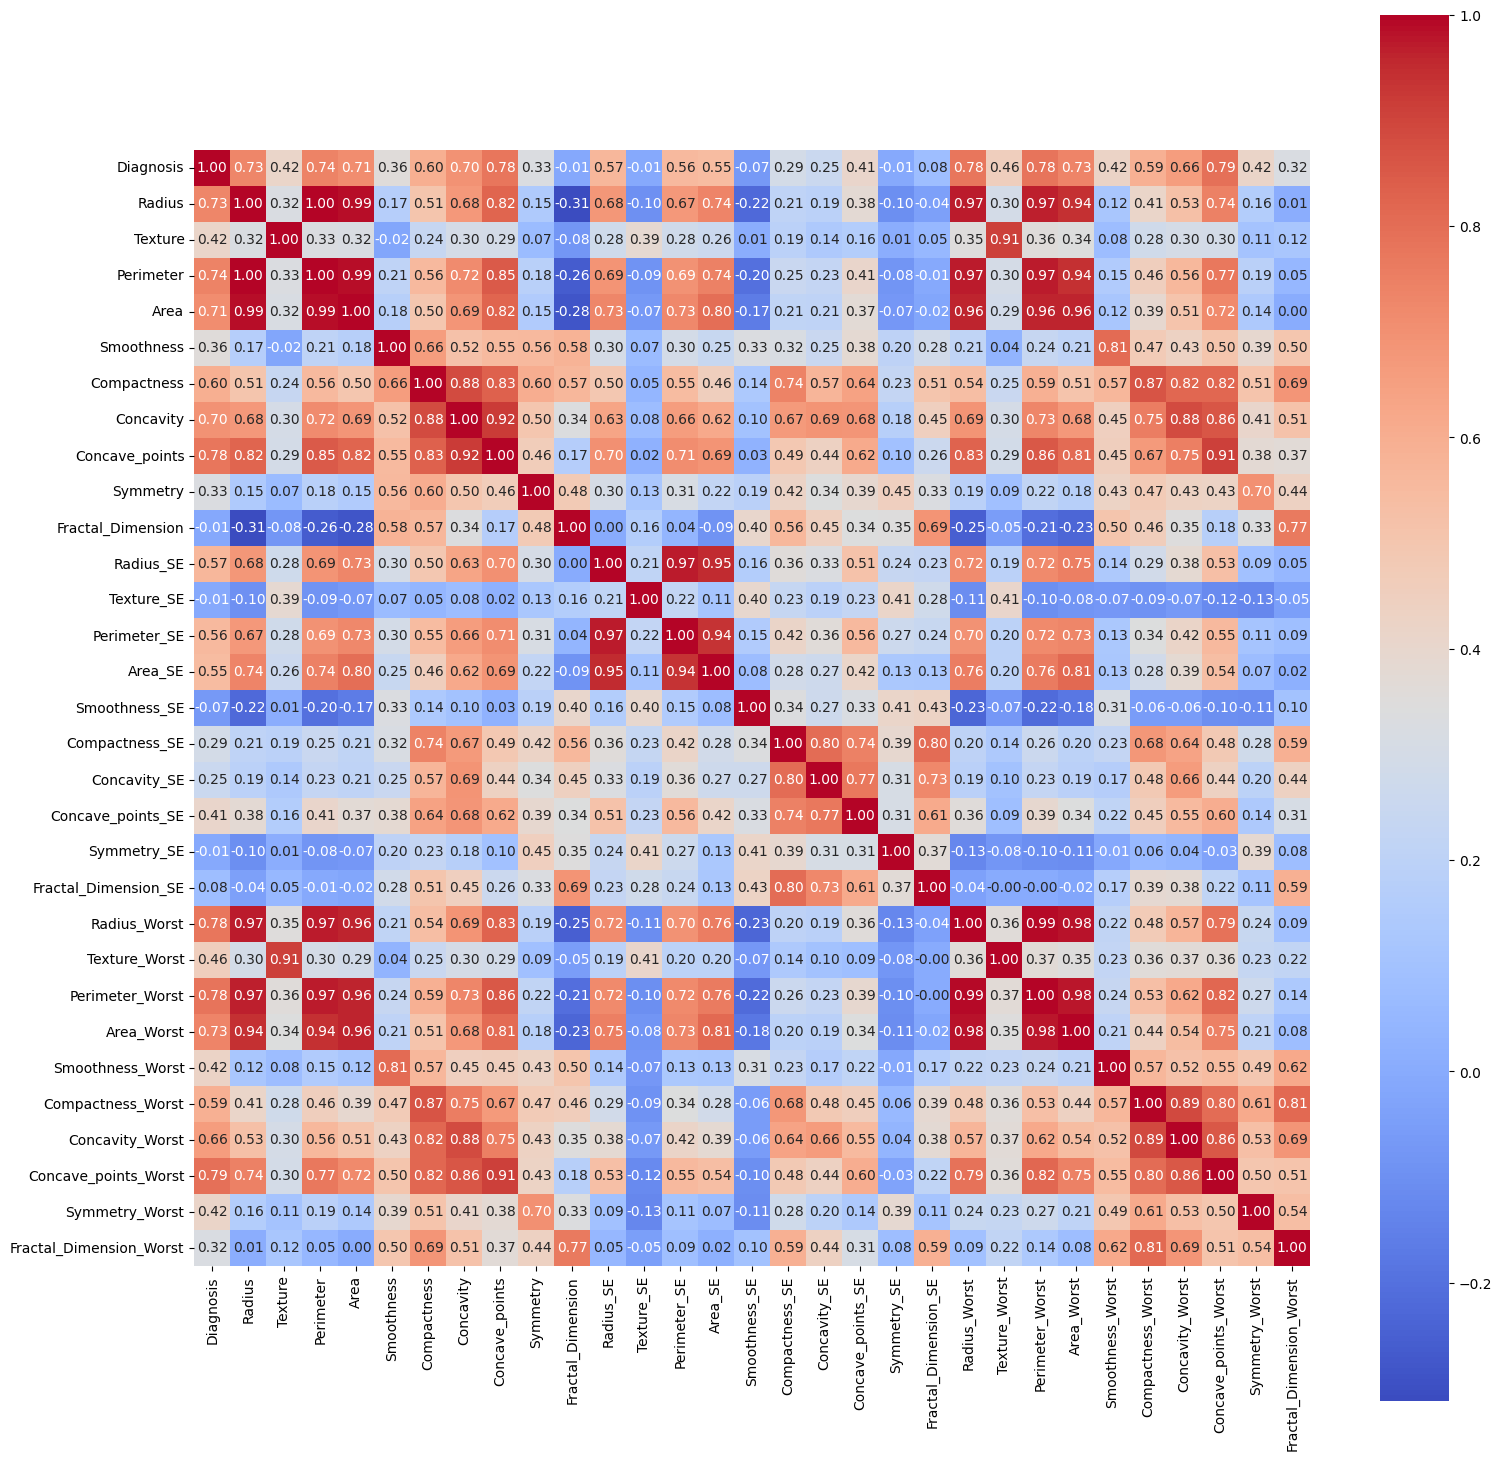

In [106]:
# 2. Visualising the data
selected_columns = ['Diagnosis','Radius','Texture','Perimeter','Area','Smoothness','Compactness','Concavity','Concave_points','Symmetry','Fractal_Dimension','Radius_SE','Texture_SE','Perimeter_SE','Area_SE','Smoothness_SE','Compactness_SE','Concavity_SE','Concave_points_SE','Symmetry_SE','Fractal_Dimension_SE','Radius_Worst','Texture_Worst','Perimeter_Worst','Area_Worst','Smoothness_Worst','Compactness_Worst','Concavity_Worst','Concave_points_Worst','Symmetry_Worst','Fractal_Dimension_Worst']

# correlation matrix
corr_matrix = df[selected_columns].corr()

plt.figure(figsize=(18, 18))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", square=True, cmap='coolwarm')
plt.show()
            

There are quite a few features which have a correlation score of over 0.9 with another feature. I will begin with using 0.9 as the cutoff point for removing correlated features.
I will compare these results with feature importance to remove the least important of the 2.

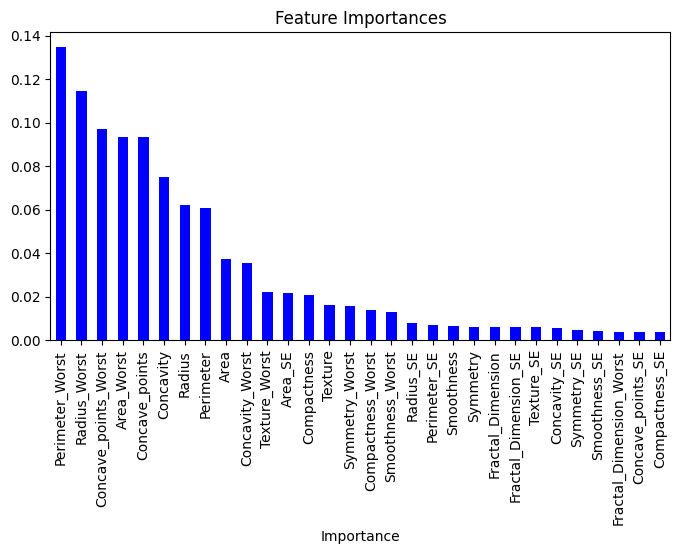

Feature pair (Radius, Perimeter) has a correlation score of 0.9978552814938109
Feature pair (Radius, Area) has a correlation score of 0.9873571700566127
Feature pair (Radius, Radius_Worst) has a correlation score of 0.9695389726112055
Feature pair (Radius, Perimeter_Worst) has a correlation score of 0.9651365139559871
Feature pair (Radius, Area_Worst) has a correlation score of 0.9410824595860461
Feature pair (Texture, Texture_Worst) has a correlation score of 0.912044588840421
Feature pair (Perimeter, Area) has a correlation score of 0.9865068039913907
Feature pair (Perimeter, Radius_Worst) has a correlation score of 0.9694763634663146
Feature pair (Perimeter, Perimeter_Worst) has a correlation score of 0.9703868870426394
Feature pair (Perimeter, Area_Worst) has a correlation score of 0.9415498080023068
Feature pair (Area, Radius_Worst) has a correlation score of 0.9627460860470841
Feature pair (Area, Perimeter_Worst) has a correlation score of 0.9591195743552645
Feature pair (Area, A

In [107]:
# Fit a random forest classifier
y = df['Diagnosis']
X = df.drop('Diagnosis', axis=1)
clf = RandomForestClassifier()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf.fit(X_train,y_train)

# Get feature importances
importances = clf.feature_importances_
importance_series = pd.Series(importances, index=X.columns)
# Sort the series by importance
sorted_importances = importance_series.sort_values(ascending=False)

# Create a bar plot
plt.figure(figsize=(8,4))
sorted_importances.plot(kind='bar', color='blue')
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.show()
# columns to drop
cols_to_drop = set()

corr_matrix = df.corr()

# Iterate over the correlation matrix and drop the feature with the lowest importance score in each pair of highly correlated features
for i in range(corr_matrix.shape[0]):
    for j in range(i+1, corr_matrix.shape[1]):
        if abs(corr_matrix.iloc[i, j]) > 0.9:
            print(f"Feature pair ({corr_matrix.columns[i]}, {corr_matrix.columns[j]}) has a correlation score of {corr_matrix.iloc[i, j]}")
            # If neither of the features in the pair have been removed before
            if corr_matrix.columns[i] not in cols_to_drop and corr_matrix.columns[j] not in cols_to_drop:
                # Add the feature with the lowest importance score to the set of features to remove
                if importance_series[corr_matrix.columns[i]] > importance_series[corr_matrix.columns[j]]:
                    cols_to_drop.add(corr_matrix.columns[j])
                else:
                    cols_to_drop.add(corr_matrix.columns[i])



# Drop the columns
# I am not going to drop the columns yet, I will run tests with and without the columns to see the difference in.
#df = df.drop(cols_to_drop, axis=1)
print(f"Columns to be dropped: {cols_to_drop}")

Looking at the feature importance graphs, and then the list of columns to be dropped, there are quite a few features which are of high importance which are being removed, which makes me nervous. I'll compare scores before and after removing these columns to make sure it benefits the models.

Looking at these visualisations of each feature in the data, some of the graphs have quite a clear divide between the Benign and Malignant diagnoses, with a small overlap, such as concave points, radius worst, perimeter worst, area worst, concave points worst.
There are others which have do not have a clear divide, and so perhaps will not be as important of a feature for the diagnosis.

In [108]:
# Preliminary Model Training - Testing and scoring a selection of classifiers before feature engineering so I can compare results after.

#y = df['Diagnosis']
#X = df.drop('Diagnosis', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scores = {}

# List of classifiers
classifiers = [
    (RandomForestClassifier(), "RandomForestClassifier"),
    (RandomForestRegressor(), "RandomForestRegressor"),
    (SVC(), "SVC"),
    (KNeighborsClassifier(), "KNeighborsClassifier"),
    (GradientBoostingClassifier(), "GradientBoostingClassifier"),
    (MLPClassifier(max_iter=1000), "MLPClassifier"),
    (AdaBoostClassifier(algorithm="SAMME"), "AdaBoostClassifier"),
    (ExtraTreesClassifier(), "ExtraTreesClassifier"),
    (BaggingClassifier(), "BaggingClassifier")
]

# Train and score each classifier
for clf, clf_name in classifiers:
    clf.fit(X_train, y_train)
    scores[clf_name] = clf.score(X_test, y_test)

# Print scores in descending order
sorted_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)
for key, value in sorted_scores:
    print(f'{key} score: {value}')

ExtraTreesClassifier score: 0.9736842105263158
RandomForestClassifier score: 0.9649122807017544
AdaBoostClassifier score: 0.9649122807017544
KNeighborsClassifier score: 0.956140350877193
GradientBoostingClassifier score: 0.956140350877193
MLPClassifier score: 0.956140350877193
BaggingClassifier score: 0.956140350877193
SVC score: 0.9473684210526315
RandomForestRegressor score: 0.852983688175565


In [109]:
# List of classifiers with balanced class weights
scores_balanced_classifiers = {}
classifiers_balanced = [
    (RandomForestClassifier(class_weight='balanced'), "RandomForestClassifier"),
    (SVC(class_weight='balanced'), "SVC"),
    (ExtraTreesClassifier(class_weight='balanced'), "ExtraTreesClassifier"),
]

# Train and score each classifier
for clf, clf_name in classifiers_balanced:
    clf.fit(X_train, y_train)
    scores_balanced_classifiers[clf_name] = clf.score(X_test, y_test)
    
# Print scores in descending order
sorted_scores = sorted(scores_balanced_classifiers.items(), key=lambda x: x[1], reverse=True)
for key, value in sorted_scores:
    print(f'{key} score after class weight balanced: {value}. A difference of {value - scores[key]}')

ExtraTreesClassifier score after class weight balanced: 0.9736842105263158. A difference of 0.0
RandomForestClassifier score after class weight balanced: 0.9649122807017544. A difference of 0.0
SVC score after class weight balanced: 0.9385964912280702. A difference of -0.00877192982456132


I wanted to see if having a balanced class weight on these classifiers would make a difference to the scores. 
It had a minimal impact.

In [110]:
#Printing scores after the removal of the columns
X = df.drop(list(cols_to_drop) + ['Diagnosis'], axis=1)
print(X.columns)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scores_after_columns_removed = {}

# Train and score each classifier
for clf, clf_name in classifiers:
    clf.fit(X_train, y_train)
    scores_after_columns_removed[clf_name] = clf.score(X_test, y_test)

# Print scores in descending order
sorted_scores = sorted(scores_after_columns_removed.items(), key=lambda x: x[1], reverse=True)
for key, value in sorted_scores:
    print(f'{key} score after columns removed: {value}. A difference of {value - scores[key]}')
    
# print average difference of scores
average_difference = np.mean([value - scores[key] for key, value in sorted_scores])
print(f'\nAverage difference in scores after removing columns: {average_difference}')


Index(['Smoothness', 'Compactness', 'Symmetry', 'Fractal_Dimension',
       'Texture_SE', 'Area_SE', 'Smoothness_SE', 'Compactness_SE',
       'Concavity_SE', 'Concave_points_SE', 'Symmetry_SE',
       'Fractal_Dimension_SE', 'Texture_Worst', 'Perimeter_Worst',
       'Smoothness_Worst', 'Compactness_Worst', 'Concavity_Worst',
       'Concave_points_Worst', 'Symmetry_Worst', 'Fractal_Dimension_Worst'],
      dtype='object')
ExtraTreesClassifier score after columns removed: 0.9736842105263158. A difference of 0.0
AdaBoostClassifier score after columns removed: 0.9649122807017544. A difference of 0.0
RandomForestClassifier score after columns removed: 0.956140350877193. A difference of -0.00877192982456143
SVC score after columns removed: 0.956140350877193. A difference of 0.00877192982456143
KNeighborsClassifier score after columns removed: 0.956140350877193. A difference of 0.0
GradientBoostingClassifier score after columns removed: 0.956140350877193. A difference of 0.0
BaggingClassif

Removing columns has caused a minimal change in score overall,

In [111]:
from sklearn.model_selection import cross_val_score

# Dictionary to store cross-validation scores
cv_scores = {}

# Perform cross-validation for each classifier
for clf, clf_name in classifiers:
    scores = cross_val_score(clf, X, y, cv=5)  # 5-fold cross-validation
    cv_scores[clf_name] = scores.mean()

# Print cross-validation scores in descending order
sorted_scores = sorted(cv_scores.items(), key=lambda x: x[1], reverse=True)
for key, value in sorted_scores:
    print(f'{key} cross-validation score: {value}')

ExtraTreesClassifier cross-validation score: 0.9648657040832169
AdaBoostClassifier cross-validation score: 0.9648657040832168
GradientBoostingClassifier cross-validation score: 0.9596180717279925
RandomForestClassifier cross-validation score: 0.9578326346840551
MLPClassifier cross-validation score: 0.9385343890700202
SVC cross-validation score: 0.9332557056357709
KNeighborsClassifier cross-validation score: 0.9279770222015216
BaggingClassifier cross-validation score: 0.9279149200434716
RandomForestRegressor cross-validation score: 0.7950043480016162


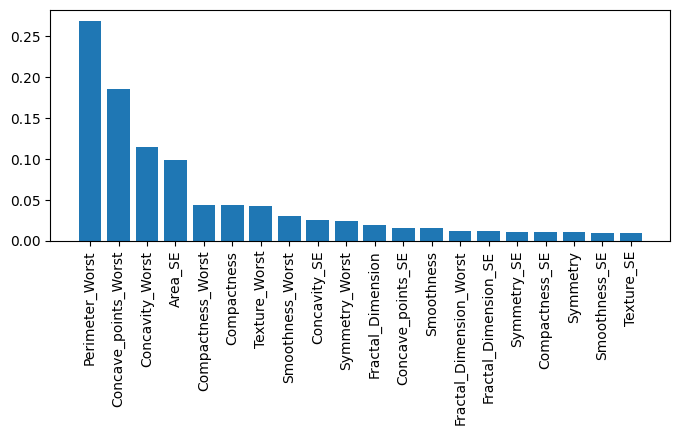

In [112]:
# 4. Feature Engineering
#y = df['Diagnosis']
#X = df.drop('Diagnosis', axis=1)

# Scaling my numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
#print(f"ExtraTreesClassifier score before removing features: {rfc.score(X_test, y_test)}")

etc_score = cross_val_score(rfc, X_scaled, y, cv=5)
#print(f"ExtraTreesClassifier score before removing features: {etc_score.mean()}")

# visualizing feature importance
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(8, 3))
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.show()

The most important feature is concave_points_worst, then after that the concave, radius, perimeter, area and concavity take up the next 10 important features.

SVC - Max score: 0.9718984962406015 with 8 features
KNeighbors Classifier - Max score: 0.9595551378446115 with 7 features
Extra Trees Classifier - Max score: 0.968421052631579 with 12 features


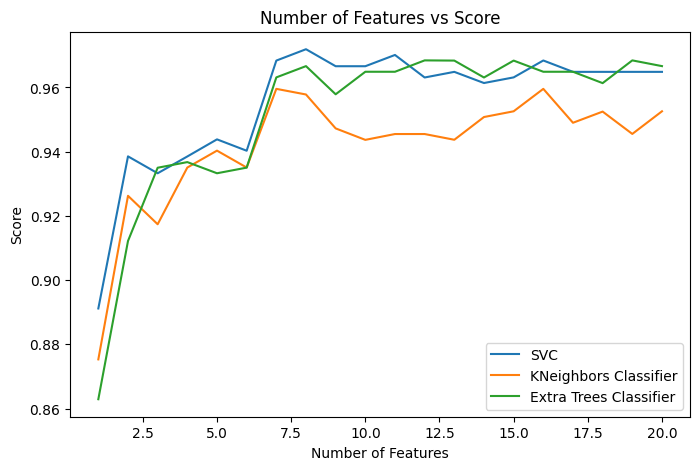

In [133]:
# Using pipeline and SelectKBest to find the optimal amount of usable features.

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import KFold

# shortened list of classifiers for easier testing
classifiers = [
    (SVC(probability=True), "SVC"),
    (KNeighborsClassifier(), "KNeighbors Classifier"),
    (ExtraTreesClassifier(), "Extra Trees Classifier")
]

''' Full List of Classifiers
classifiers = [
    (RandomForestClassifier(), "Random Forest Classifier"),
    (SVC(), "SVC"),
    (KNeighborsClassifier(), "KNeighbors Classifier"),
    (GradientBoostingClassifier(), "Gradient Boosting Classifier"),
    (MLPClassifier(max_iter=1000), "MLP Classifier"),
    (LogisticRegression(max_iter=1000), "Logistic Regression"),
    (AdaBoostClassifier(algorithm="SAMME"), "AdaBoost Classifier"),
    (ExtraTreesClassifier(), "Extra Trees Classifier"),
    (BaggingClassifier(), "Bagging Classifier")
]
'''
plt.figure(figsize=(8, 5))

selected_features_dict = {}

for clf, clf_type in classifiers:
    features_scores = []
    for i in range(1,len(X.columns)+1):
        pipeline = Pipeline([
            ('selector', SelectKBest(score_func=f_classif, k=i)),
            ('classifier', clf)
        ])
        scores = cross_val_score(pipeline, X_scaled, y, cv=KFold(n_splits=10))
        mean_score = scores.mean()
        features_scores.append((i, mean_score))

    plt.plot([i[0] for i in features_scores], [i[1] for i in features_scores], label=clf_type)
    
    max_score = max(features_scores, key=lambda x: x[1])
    print(f'{clf_type} - Max score: {max_score[1]} with {max_score[0]} features')
    
    # Store the optimal number of features for this classifier in a dictionary
    selector = SelectKBest(score_func=f_classif, k=max_score[0])
    X_selected = selector.fit_transform(X_scaled, y)
    selected_features = X.columns[selector.get_support()]
    selected_features_dict[clf_type] = selected_features


plt.xlabel('Number of Features')
plt.ylabel('Score')
plt.title('Number of Features vs Score')
plt.legend()
plt.show()


I was originally using train_test_split() on ExtraTreesClassifier() but received different results on the graph each time, so I switched to cross_val_score() to be more thorough. With using train_test_split() I was often getting a max score at around 10 features, but using cross_val_score() the max score tends to be around 25 features. Out of a total of 30 features, I won't be losing many features to help the models run more efficiently. I then put this pipeline inside a for loop to iterate through each of my classifiers in my classifiers list. There is a trend across all of them to increase at around 17, and peak around 25.


In [114]:
# 6. Model Training - Testing and scoring a selection of classifiers after feature engineering 

scores = {}

for clf_name, features in selected_features_dict.items():
    
    X_selected = X_scaled[features]
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
    
    clf_name.fit(X_train, y_train)   
    scores[clf_name] = clf_name.score(X_test, y_test)
    print(f'{clf_name} - Score: {scores[clf_name]}')
    print(classification_report(y_test, clf_name.predict(X_test)))

SVC(probability=True) - Score: 0.9736842105263158
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        71
           1       0.98      0.95      0.96        43

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

KNeighborsClassifier() - Score: 0.9649122807017544
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        71
           1       0.95      0.95      0.95        43

    accuracy                           0.96       114
   macro avg       0.96      0.96      0.96       114
weighted avg       0.96      0.96      0.96       114

ExtraTreesClassifier() - Score: 0.956140350877193
              precision    recall  f1-score   support

           0       0.95      0.99      0.97        71
           1       0.97      0.91      0.94        43

    accuracy                   

Highest scoring classifier after feature engineering is ExtraTreesClassifier
I will use GridSearchCV to find the optimal hyperparameters for this classifier

Best parameters for SVC using GridSearchCV: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Best score for SVC using GridSearchCV: 0.9736263736263737
ROC AUC score for SVC: 0.9697019325253848
Classification report for SVC:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        71
           1       0.98      0.95      0.96        43

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

Best parameters for KNeighbors Classifier using GridSearchCV: {'metric': 'euclidean', 'n_neighbors': 8, 'weights': 'uniform'}
Best score for KNeighbors Classifier using GridSearchCV: 0.9604395604395604
ROC AUC score for KNeighbors Classifier: 0.9697019325253848
Classification report for KNeighbors Classifier:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        71
           1       0.98      0.95     

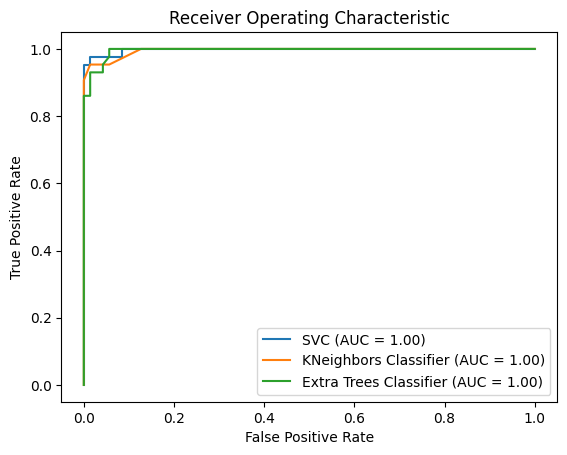

In [118]:
# 8. Hyperparameter Tuning - GridSearchCV and RandomizedSearchCV

param_grids = {
    'SVC': {
        'C': [0.1, 1, 10, 100], 
        'gamma': [1, 0.1, 0.01, 0.001],
        'kernel': ['rbf', 'poly', 'sigmoid']
    },
    'KNeighbors Classifier': {
        'n_neighbors': list(range(1, 31)),
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski']
    },
    'Extra Trees Classifier': {
        'n_estimators': [100, 200, 300, 400, 500],
        'max_depth': [None, 10, 20, 30, 40, 50],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
    }
}


# Initialize a DataFrame to store the performance metrics
metrics_df = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC Score'])

for clf, clf_name in classifiers:
    X_selected = X_scaled[selected_features_dict[clf]]
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
    
    # Get the parameter grid for this classifier
    param_grid = param_grids[clf_name]

    grid_search = GridSearchCV(clf, param_grid=param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)
 
    print(f'Best parameters for {clf_name} using GridSearchCV: {grid_search.best_params_}')
    print(f'Best score for {clf_name} using GridSearchCV: {grid_search.best_score_}')
    print(f"ROC AUC score for {clf_name}: {roc_auc_score(y_test, y_pred)}")
    print(f"Classification report for {clf_name}:\n{classification_report(y_test, y_pred)}")  
    
    
    # 9. Using the best parameters for the top 3 classifiers to train and test the models. (It was easier to do this in the same loop)
    clf.set_params(**grid_search.best_params_)
    clf.fit(X_train, y_train)
    
    # Save the model
    dump(clf, f"{clf_name}_model.joblib")
    
    y_pred = clf.predict(X_test)
    y_score = clf.predict_proba(X_test)[:, 1]
    
    # Compute the performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_score)
    
    # Store the performance metrics in the DataFrame
    metrics_df.loc[clf_name] = [accuracy, precision, recall, f1, roc_auc]
    
    # Compute the ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_score)
    
    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f'{clf_name} (AUC = {roc_auc:.2f})')

# Add labels and legend to the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

# Display the plot
plt.show()
    

In [116]:
# Display the performance metrics
print(metrics_df,'\n')

# Find the model with the highest score
best_model = metrics_df.idxmax()

# Print the best model and its score
for metric in metrics_df.columns:
    print(f"The best model for {metric} is {best_model[metric]} with a score of {metrics_df.loc[best_model[metric], metric]}")
    
    

                        Accuracy  Precision    Recall  F1 Score  ROC AUC Score
SVC                     0.973684    0.97619  0.953488  0.964706       0.997707
KNeighbors Classifier   0.973684    0.97619  0.953488  0.964706       0.995414
Extra Trees Classifier  0.956140    0.97500  0.906977  0.939759       0.994923 

The best model for Accuracy is SVC with a score of 0.9736842105263158
The best model for Precision is SVC with a score of 0.9761904761904762
The best model for Recall is SVC with a score of 0.9534883720930233
The best model for F1 Score is SVC with a score of 0.9647058823529412
The best model for ROC AUC Score is SVC with a score of 0.9977071732721913


Here are the final scores for the 3 trained and tweaked models.
For this dataset, in the context of breast cancer diagnoses, it's important to catch as many true positive cases as possible, because the cost of a false negative (a cancer case going undiagnosed) can be very high.
Therefore the most important metrics to consider are recall, F1 and ROC AUC scores.
On the latest run of the program, SVC has the highest score from all the metrics, which makes it an easy winner. I am going to look at the support vectors and the decision boundary to try and understand why.

Index(['Compactness', 'Area_SE', 'Texture_Worst', 'Perimeter_Worst',
       'Smoothness_Worst', 'Compactness_Worst', 'Concavity_Worst',
       'Concave_points_Worst'],
      dtype='object')


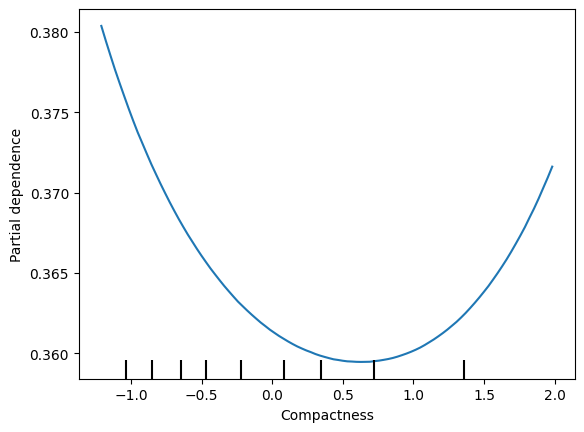

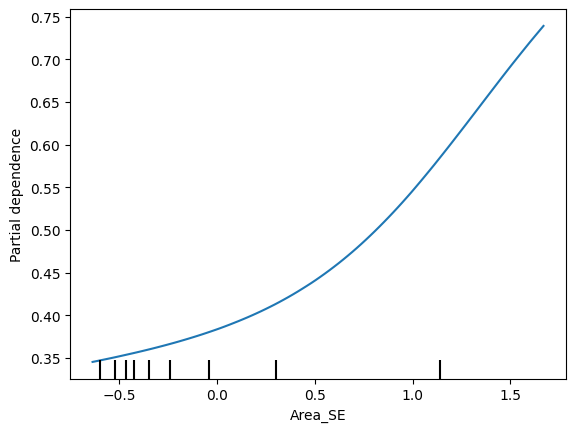

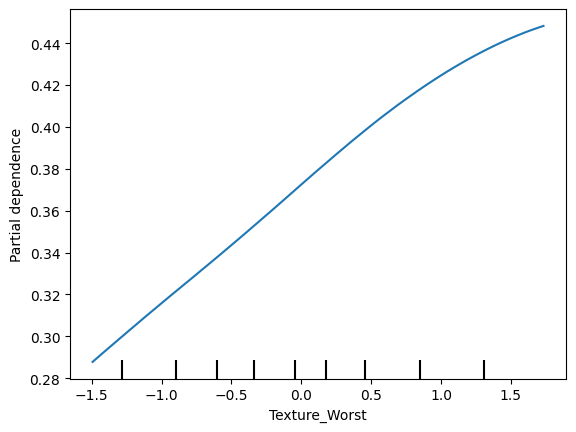

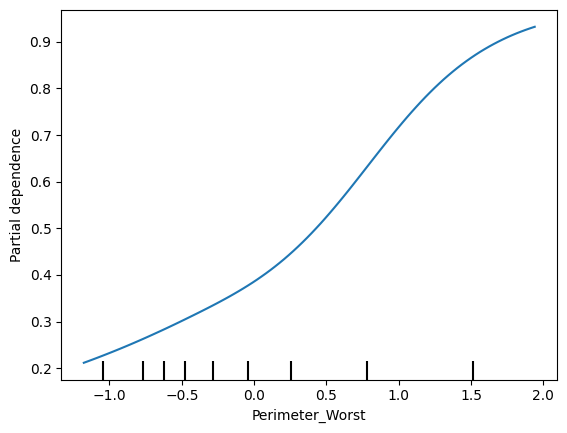

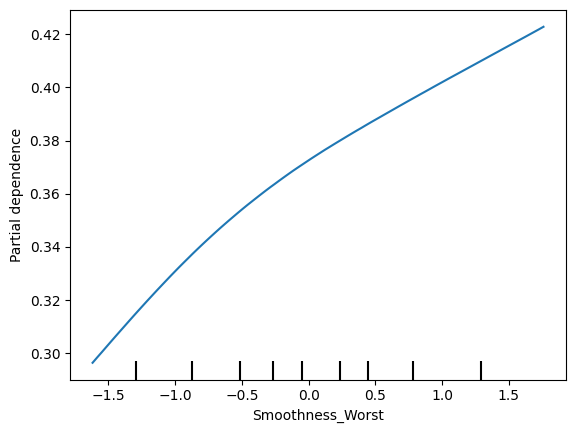

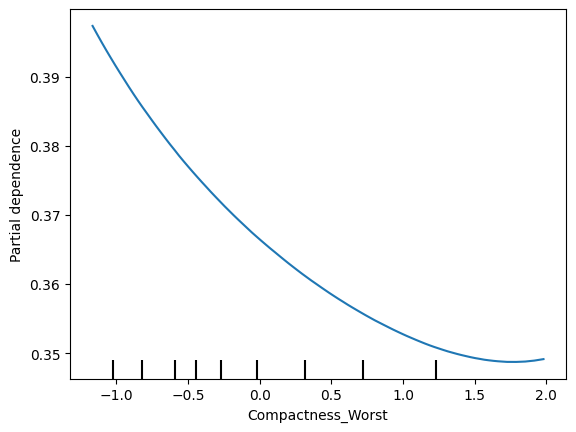

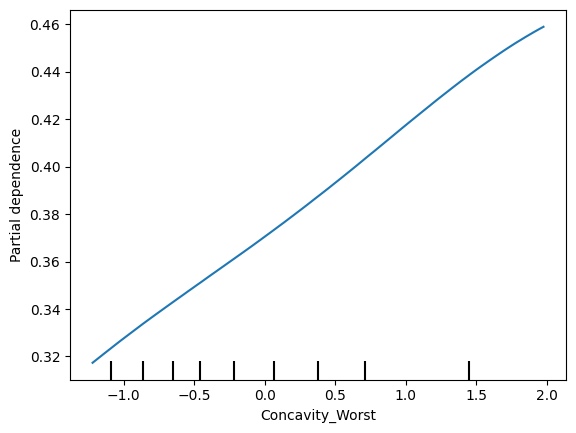

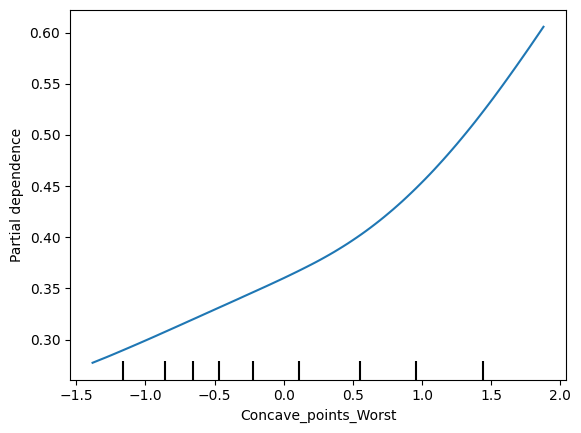

In [139]:
# Model interpretation
# Partial Dependence Plots
from sklearn.inspection import PartialDependenceDisplay

# Load in the winning SVC model
clf = load('SVC_model.joblib')
print(selected_features_dict['SVC'])
# Create a partial dependence plot for the first feature
for i in range(len(selected_features_dict['SVC'])):
    features = [i]
    X_SVC = X_scaled[selected_features_dict['SVC']]
    disp = PartialDependenceDisplay.from_estimator(clf, X_SVC, features)

    plt.show()


In [171]:
import lime
import lime.lime_tabular
import numpy as np
from joblib import load

# Load your model
clf = load('SVC_model.joblib')
# Assuming X_train is your training data and model is your trained model
# Convert DataFrame to numpy array if it's not already
X_train_np = X_train[selected_features_dict['SVC']].values

# Get the list of feature names
feature_names = X_train.columns.tolist()

# Create the LimeTabularExplainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_np,
    feature_names=feature_names,
    class_names=['0', '1'],  # replace with your actual class names
    mode='classification'  # or 'regression' if that's your use case
)

# Choose a random instance for explanation
i = np.random.randint(0, X_train_np.shape[0])
exp = explainer.explain_instance(X_train_np[i], clf.predict_proba, num_features=5)

# Show the explanation
exp.show_in_notebook(show_table=True)